## Medical Image Segmentation - Standard U-NET implementation

In [1]:
%load_ext autoreload
%autoreload 2

#### Import modules

In [2]:
import sys
from pathlib import Path
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

plt.style.use('dark_background')

2025-05-08 13:50:40.165094: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 13:50:40.252335: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 13:50:40.333638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746705040.413645   16941 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746705040.435627   16941 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746705040.564556   16941 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

#### Local imports

In [3]:
sys.path.append(str(Path(".").resolve().parent))

from scripts.experiments import InputOutput
io = InputOutput()

### Step 1 - Loading training data

In [26]:
dwi_sequence, dwi_segmentation = io.read_nrrds("../MRI_data/ROI/DWI/invivo")
sequence_header, sequence_vol = io.nrrd_to_matrix(dwi_sequence)
segmentation_header, segmentation_vol = io.nrrd_to_matrix(dwi_segmentation)

#### Pre-processing data

#### Save image volumes to an array of images

In [27]:
sequence_vol = np.concatenate(sequence_vol, axis=2)
segmentation_vol = np.concatenate(segmentation_vol, axis=2)
sequence_vol.shape, segmentation_vol.shape

((180, 224, 200), (180, 224, 200))

#### Image normalization
Succesfully training u-nets requires the image data to be standardized. The raw sequences produced by the MRI scanner contain extreme values which do not make sense to preserve in the scope of object detection. The graph below identifies there are rare extreme outliers in the complete dataset. I will clip at the 5th diviation from the mean, perserving 99.999% of the data.

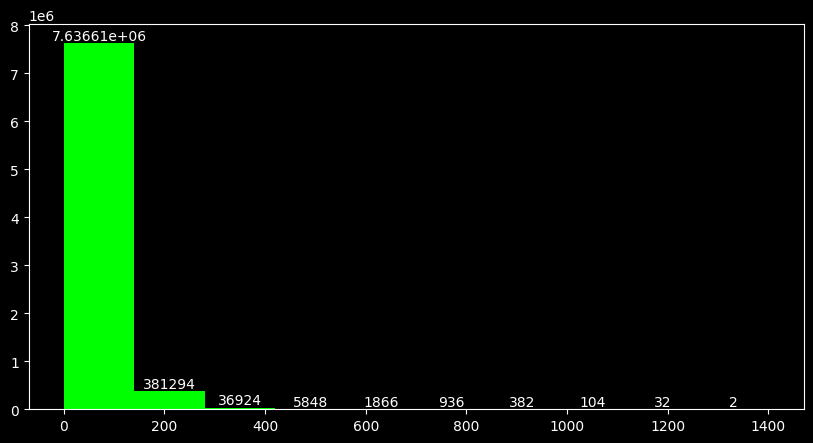

In [28]:
plt.figure(figsize=(10,5))
counts, edges, bars = plt.hist(sequence_vol.flatten(), color="lime")
plt.bar_label(bars, label_type='edge')
plt.show()

In [29]:
avg = sequence_vol.mean()
std = np.std(sequence_vol)
upper = avg + 5 * std
avg, std, upper

(np.float64(41.32679786706349),
 np.float64(51.790786200320795),
 np.float64(300.28072886866744))

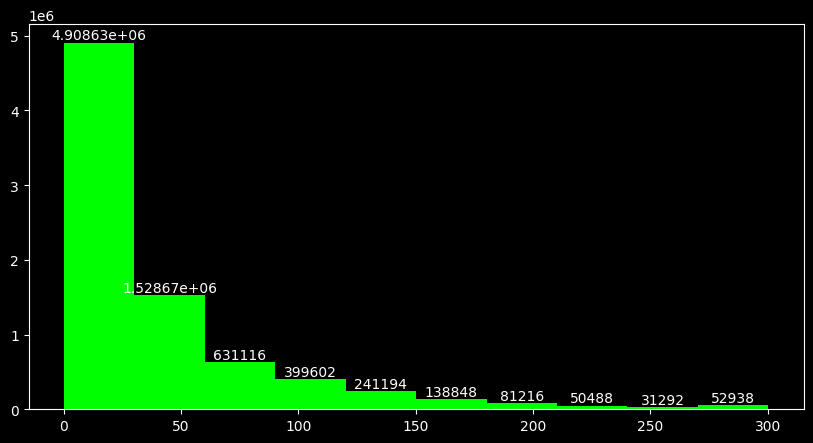

In [30]:
plt.figure(figsize=(10,5))
clipped_sequence_vol = np.clip(sequence_vol, a_min=0, a_max=upper)
counts, edges, bars = plt.hist(clipped_sequence_vol.flatten(), color="lime")
plt.bar_label(bars, label_type='edge')
plt.show()

In [31]:
sequence_vol_n = clipped_sequence_vol / clipped_sequence_vol.max()
sequence_vol.min(), sequence_vol.max(), sequence_vol_n.min(), sequence_vol_n.max()

(np.int32(0), np.int32(1400), np.float64(0.0), np.float64(1.0))

#### Sanity check for segmentation  
Our segmentation volume is supposed to have only two classes; either renal cortex `1` or not renal-cortex `0`. The code snippet below simply returns all unique values, this confirms there are only two values with a maximum of `1`.

In [32]:
np.unique(segmentation_vol)

array([0, 1], dtype=uint8)

#### Reshaping the data
It is paramount for standard u-nets to have square images having a image size in powers of two. The data we're working with is in an odd size `(104, 128)`. To combat this the image will be cropped from the sides to form an image which is `(96, 96)`.

In [33]:
sequence_vol_n.shape, segmentation_vol.shape

((180, 224, 200), (180, 224, 200))

In [35]:
sequence_vol = tf.image.pad_to_bounding_box(
    sequence_vol_n,
    offset_height=6,
    offset_width=0,      
    target_height=192,   
    target_width=224     
).numpy()

segmentation_vol = tf.image.pad_to_bounding_box(
    segmentation_vol,
    offset_height=6,
    offset_width=0,
    target_height=192,
    target_width=224
).numpy()

#### Cropped segmentation and image
After cropping the image to the closest working set of pixels, we can observe that the image is both square and and the segmentation is still fitting.

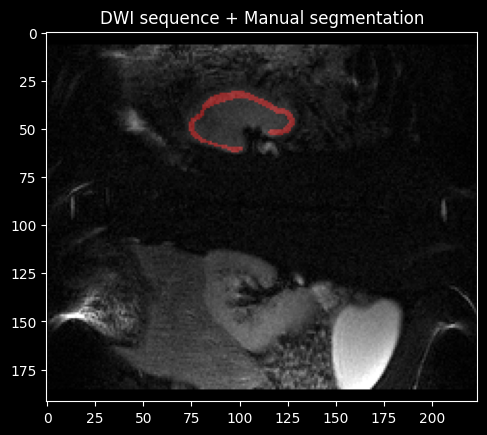

In [36]:
slc = 12
vs = segmentation_vol[...,slc]
v = sequence_vol[...,slc]
v = v / v.max()

rgb = np.stack((v+vs*0.4, v, v), axis=-1)
plt.imshow(rgb)
plt.title("DWI sequence + Manual segmentation")
plt.show()

#### Creating a Train- / Test- / Validation-set
For this particular example, the amount of samples when split in a 80 : 10 : 10 manner does not produce a remainder. These fractions will be the 80% training set and 10% test and validation set.

In [37]:
print(segmentation_vol.shape)

def train_test_validation(volume):
    pct_80 = int(volume.shape[2] / 100 * 80)
    pct_90 = int((volume.shape[2] / 100 * 90))
    pct_100 = int(volume.shape[2])
    return volume[...,0:pct_80], volume[...,pct_80: pct_90], volume[...,pct_90:pct_100]

seg_train, seg_test, seg_val = train_test_validation(segmentation_vol)
seq_train, seq_test, seq_val = train_test_validation(sequence_vol)
seg_train.shape, seg_test.shape, seg_val.shape

(192, 224, 200)


((192, 224, 160), (192, 224, 20), (192, 224, 20))

In [38]:
# For training masks
seq_train = np.transpose(seq_train, (2, 0, 1))
seq_train = np.expand_dims(seq_train, axis=-1)

# For validation masks
seq_test = np.transpose(seq_test, (2, 0, 1))
seq_test = np.expand_dims(seq_test, axis=-1)

# For validation masks
seq_val = np.transpose(seq_val, (2, 0, 1))
seq_val = np.expand_dims(seq_val, axis=-1)

In [39]:
# For training masks
seg_train = np.transpose(seg_train, (2, 0, 1))
seg_train = np.expand_dims(seg_train, axis=-1)

# For validation masks
seg_test = np.transpose(seg_test, (2, 0, 1))
seg_test = np.expand_dims(seg_test, axis=-1)

# For validation masks
seg_val = np.transpose(seg_val, (2, 0, 1))
seg_val = np.expand_dims(seg_val, axis=-1)

In [40]:
dwi_data = {"seg_test": seg_test,
            "seq_test": seq_test,
            "seg_train": seg_train,
            "seq_train": seq_train,
            "seg_val": seg_val,
            "seq_val": seq_val}

In [41]:
import pickle

with open("../data/processed/DWI_invivo_data.pkl", mode="b+w") as p_out:
    pickle.dump(dwi_data, p_out)

### Step 2 - Declaring U-net

In [42]:
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from keras.models import Model, Sequential

In [43]:
def convolutional_operaration(input_tensor, filters=64):
    # Convolutional block one
    conv1 = Conv2D(filters, kernel_size=(3,3), padding="same")(input_tensor)
    batch_norm1 = BatchNormalization()(conv1)
    activation1 = ReLU()(batch_norm1)

    # Convolutional block two
    conv2 = Conv2D(filters, kernel_size=(3,3), padding="same")(activation1)
    batch_norm2 = BatchNormalization()(conv2)
    activation2 = ReLU()(batch_norm2)

    return activation2

In [44]:
def encoder(entered_input, filters=64):
    enc = convolutional_operaration(entered_input, filters)
    maxpo = MaxPooling2D(strides=(2,2))(enc)
    return enc, maxpo

In [45]:
def decoder(entered_input, skip, filters=64):
    upsample = Conv2DTranspose(filters, (2,2), strides=2, padding="same")(entered_input)
    connection = Concatenate()([upsample, skip])
    out = convolutional_operaration(connection, filters)
    return out

In [46]:
def U_net(imagesize):

    inputs = Input(imagesize)

    # encoding phase
    skip_1, encoder_1 = encoder(inputs, filters=64)
    skip_2, encoder_2 = encoder(encoder_1, filters=64*2)
    skip_3, encoder_3 = encoder(encoder_2, filters=64*4)
    skip_4, encoder_4 = encoder(encoder_3, filters=64*8)

    # Bottom U
    convolutioal = convolutional_operaration(encoder_4, filters=64*16)

    # decoding phase
    decoder_1 = decoder(convolutioal, skip_4, filters=64*8)
    decoder_2 = decoder(decoder_1, skip_3, filters=64*4)
    decoder_3 = decoder(decoder_2, skip_2, filters=64*2)
    decoder_4 = decoder(decoder_3, skip_1, filters=64)

    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(inputs, out)

    return model

In [48]:
input_shape = (192, 224, 1,)
model = U_net(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 192, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 192, 224,  │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 224,  │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 192, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 192, 224,  │     36,928 │ re_lu_24[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 224,  │        256 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 192, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 96, 112,   │          0 │ re_lu_25[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 96, 112,   │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 112,   │        512 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 96, 112,   │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 96, 112,   │    147,584 │ re_lu_26[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 112,   │        512 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 96, 112,   │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 48, 56,    │          0 │ re_lu_27[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 48, 56,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 56,    │      1,024 │ conv2d_28[0][0] 

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
            "../models/unet_prototype_1.model.keras",
            monitor="val_loss",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
            initial_value_threshold=None,
    )
]

### Step 3 - Training the model

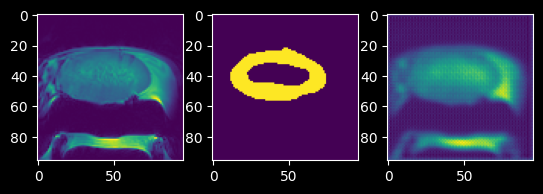

In [73]:
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(seq_test[3])
axarr[1].imshow(seg_test[3])
axarr[2].imshow(predictions[3])
plt.show()

#### Prototype 2

In [50]:
input_shape = (192, 224, 1,)
model = U_net(input_shape)

model.compile(optimizer=keras.optimizers.RMSprop(
    learning_rate=1e-5),
    loss="binary_crossentropy")
model.save("../models/unet_DWI_invivo_untrained.model.keras")

In [80]:
history2 = model.fit(seq_train, seg_train,
                    epochs=2,
                    validation_data=(seq_val, seg_val),
                    callbacks=callbacks
                    )

Epoch 1/2
15/15 ━━━━━━━━━━━━━━━━━━━━ 472s 30s/step - loss: 0.3785 - val_loss: 0.6051
Epoch 2/2
15/15 ━━━━━━━━━━━━━━━━━━━━ 469s 31s/step - loss: 0.1568 - val_loss: 0.5560


In [81]:
predictions = model.predict(seq_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step


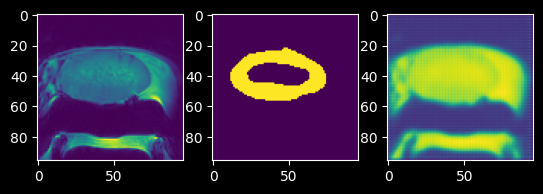

In [95]:
# Plotting
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(seq_test[3])
axarr[1].imshow(seg_test[3])
axarr[2].imshow(predictions[3])
plt.show()

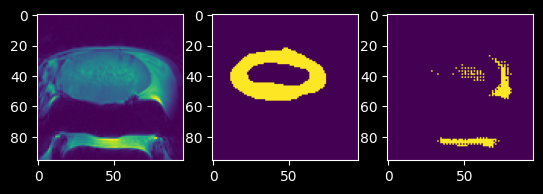

In [109]:
t = predictions[3].max() * .98
above_t = predictions[3] > t
mt = np.zeros_like(predictions[3])
mt[above_t] = 1

# Plotting
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(seq_test[3])
axarr[1].imshow(seg_test[3])
axarr[2].imshow(mt)
plt.show()